<a href="https://colab.research.google.com/github/mrhamedani/Gen-AI-projects-Pytorch/blob/main/AnimeFaces_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import zipfile
import os
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# dataset: https://www.kaggle.com/datasets/splcher/animefacedataset

I used this dataset using Kaggel API and using Google colab, but there are other ways

In [6]:
!kaggle datasets download -d splcher/animefacedataset
with zipfile.ZipFile('animefacedataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/animefacedataset')
data_path = "/content/animefacedataset"
print(os.listdir(data_path))

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
 96% 380M/395M [00:03<00:00, 164MB/s]
100% 395M/395M [00:03<00:00, 127MB/s]
['images']


In [8]:
transform = T.Compose([T.Resize((64, 64)),T.ToTensor(),T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
train_data = ImageFolder(root=data_path, transform=transform)
batch_size = 128
train_loader = DataLoader(dataset=train_data,batch_size=batch_size, shuffle=True)

torch.Size([3, 64, 64])


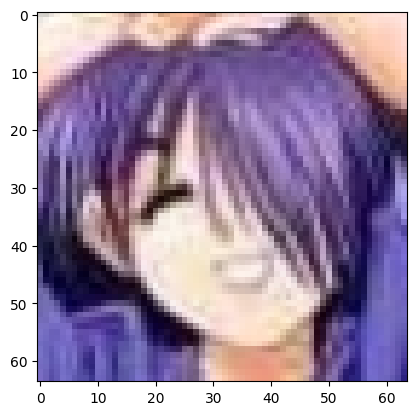

In [9]:
image0, _ = train_data[0]
print(image0.shape) # 3 x 64 x 64 input image but 64 x 64 x 3 input image for matplotlib
plt.imshow(image0.permute(1,2,0)*0.5+0.5) # 64 x 64 x 3 & unnormalize+untransform
plt.show()

# Building a Deep Convolutional GAN (DCGAN):
 ## 1. D is Discriminator

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
D = nn.Sequential(
    nn.Conv2d(3, 64, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 512, 4, 2, 1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 1, 4, 1, 0, bias=False),
    nn.Sigmoid(),
    nn.Flatten()).to(device)

## 2.	G is Generator

In [11]:
G=nn.Sequential(
    nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
    nn.Tanh()).to(device)

In [12]:
loss_fn=nn.BCELoss()
lr = 0.0002
optimG = torch.optim.Adam(G.parameters(),
                         lr = lr, betas=(0.5, 0.999))
optimD = torch.optim.Adam(D.parameters(),
                         lr = lr, betas=(0.5, 0.999))

#  Train and Use DCGAN :

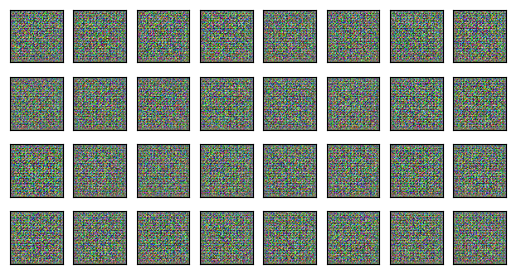

In [13]:
def test_epoch():
    noise=torch.randn(32,100,1,1).\
        to(device=device)    #A
    fake_samples=G(noise).cpu().detach()    #B
    for i in range(32):    #C
        ax = plt.subplot(4, 8, i + 1)
        img=(fake_samples.cpu().detach()[i]/2+0.5).\
            permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.show()
test_epoch()    #D

In [14]:
real_labels=torch.ones((batch_size,1)).to(device)
fake_labels=torch.zeros((batch_size,1)).to(device)

In [15]:
def train_D_on_real(real_samples):
    real_samples=real_samples.to(device)
    preds=D(real_samples)
    labels=torch.ones((real_samples.shape[0],1)).to(device)
    loss_D=loss_fn(preds,labels)
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()
    return loss_D

In [16]:
def train_D_on_fake():
    noise=torch.randn(batch_size,100,1,1).to(device)
    generated_data=G(noise)
    preds=D(generated_data)
    loss_D=loss_fn(preds,fake_labels)
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()
    return loss_D

In [17]:
def train_G():
    noise=torch.randn(batch_size,100,1,1).to(device)
    generated_data=G(noise)
    preds=D(generated_data)
    loss_G=loss_fn(preds,real_labels)
    optimG.zero_grad()
    loss_G.backward()
    optimG.step()
    return loss_G

epoch 1, dloss: 0.5901957750320435, gloss 6.612967014312744


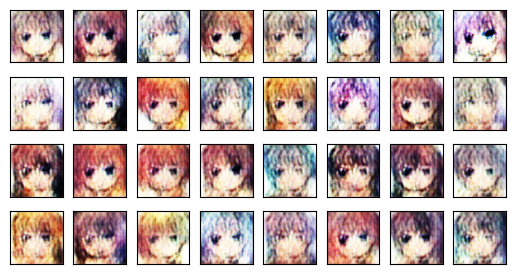

epoch 2, dloss: 0.4639494717121124, gloss 6.913917064666748


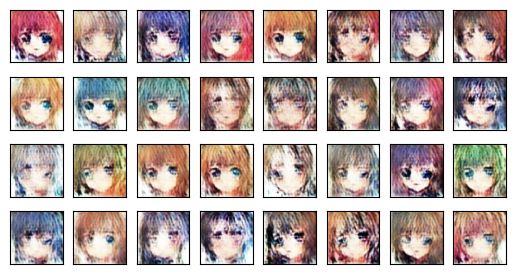

epoch 3, dloss: 0.3905216157436371, gloss 6.870280742645264


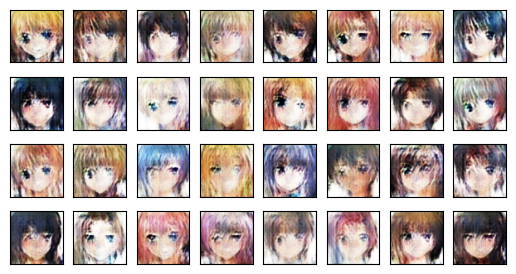

epoch 4, dloss: 0.3508583903312683, gloss 7.23123836517334


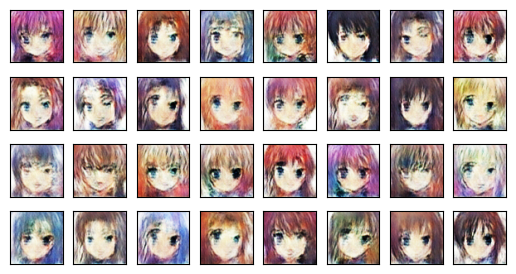

epoch 5, dloss: 0.34299853444099426, gloss 7.197823524475098


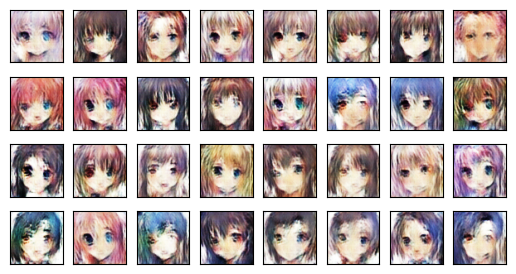

epoch 6, dloss: 0.3419421911239624, gloss 7.15667200088501


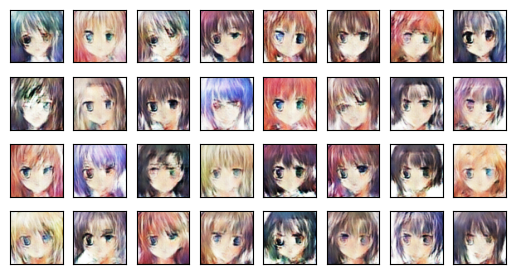

epoch 7, dloss: 0.35486772656440735, gloss 7.245542049407959


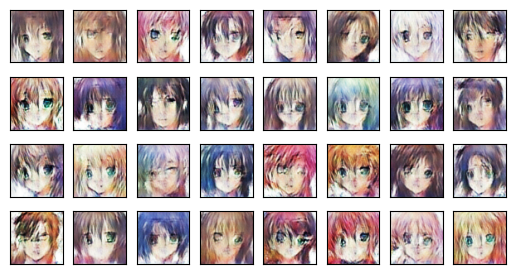

epoch 8, dloss: 0.2965626120567322, gloss 6.582198143005371


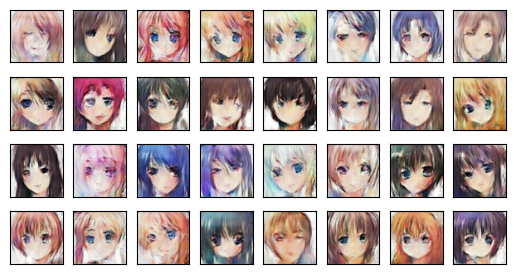

epoch 9, dloss: 0.3269374370574951, gloss 6.645991325378418


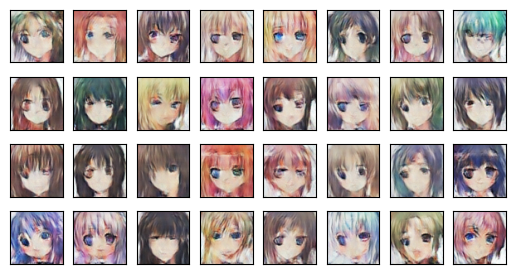

epoch 10, dloss: 0.34446612000465393, gloss 6.718159198760986


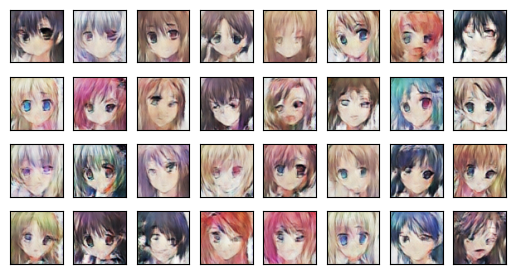

epoch 11, dloss: 0.29817795753479004, gloss 6.385329723358154


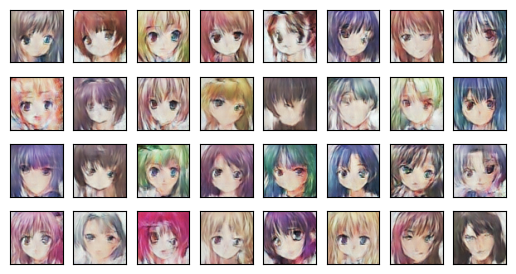

epoch 12, dloss: 0.32933309674263, gloss 6.521341800689697


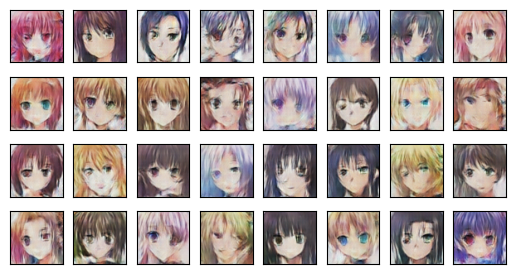

epoch 13, dloss: 0.31861022114753723, gloss 6.141963005065918


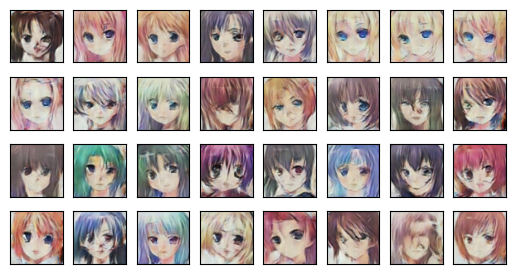

epoch 14, dloss: 0.32140833139419556, gloss 6.105874538421631


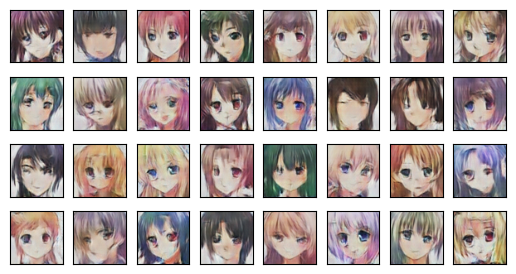

epoch 15, dloss: 0.3073996901512146, gloss 6.032145977020264


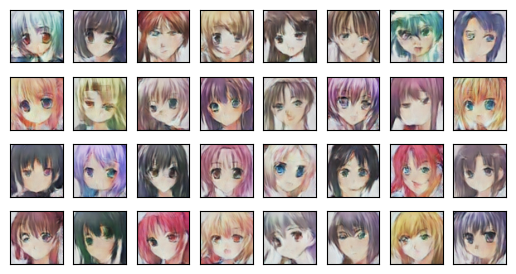

epoch 16, dloss: 0.36539220809936523, gloss 5.686394691467285


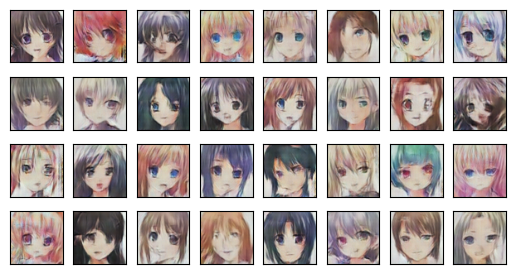

epoch 17, dloss: 0.30905383825302124, gloss 5.9018235206604


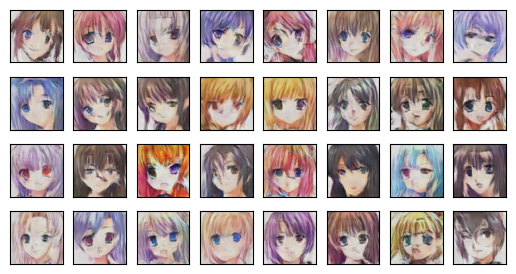

epoch 18, dloss: 0.2875745892524719, gloss 5.775664329528809


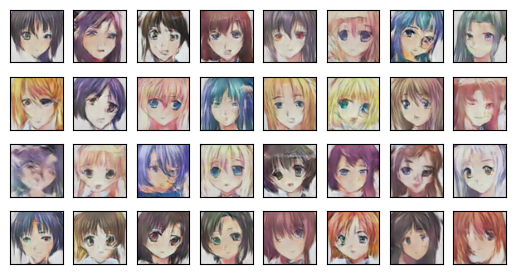

epoch 19, dloss: 0.3745463192462921, gloss 5.545014381408691


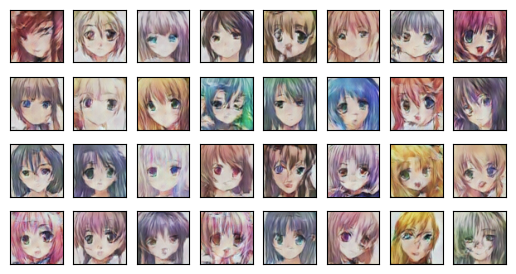

epoch 20, dloss: 0.3237802982330322, gloss 5.768301963806152


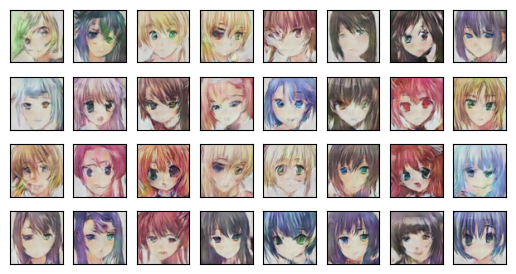

In [18]:
for i in range(20):
    gloss=0
    dloss=0
    for n, (real_samples,_) in enumerate(train_loader):

        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G=train_G()
        gloss+=loss_G
    gloss=gloss/n
    dloss=dloss/n
    print(f"epoch {i+1}, dloss: {dloss}, gloss {gloss}")
    test_epoch()